### Data: HetRec 2011 MovieLens + IMDb/Rotten Tomatoes
https://grouplens.org/datasets/hetrec-2011/
readme: http://files.grouplens.org/datasets/hetrec2011/hetrec2011-movielens-readme.txt

In [1]:
from freshgraph import data_loader
from freshgraph.data_loader import user_item_tuple_train, movie_meta, movies_validate, movie_genres, movie_tags
import matplotlib.pyplot as plt
import numpy as np

## load data into graph structure

In [2]:
%%time
movie_feature_graph = data_loader.get_graph()

Number of nodes 35743 and number of edges 74190 in graph.
CPU times: user 9.75 s, sys: 40.5 ms, total: 9.79 s
Wall time: 9.8 s


### Step 1: candidating

In [3]:
import warnings
warnings.filterwarnings('ignore')
## tensorflow warning supression
from freshgraph import candidating

#### create metapath2vec based model for item to item similarity

##### Step 1: training similarity model

In [ ]:
%%time
# training will take about 20+- mins, once trained this step can be skipped
metapath2vec_model = candidating.train_candidates_model(movie_feature_graph)
metapath2vec_model.save("movie.model")

##### step 1: load trained model

In [4]:
%%time
from gensim.models import Word2Vec
metapath2vec_model = Word2Vec.load("movie.model")

CPU times: user 278 ms, sys: 37.8 ms, total: 316 ms
Wall time: 387 ms


In [5]:
movies_validate[:10]

,id,title,imdbID,spanishTitle,imdbPictureURL,year,rtID,rtAllCriticsRating,rtAllCriticsNumReviews,rtAllCriticsNumFresh,...,rtAllCriticsScore,rtTopCriticsRating,rtTopCriticsNumReviews,rtTopCriticsNumFresh,rtTopCriticsNumRotten,rtTopCriticsScore,rtAudienceRating,rtAudienceNumRatings,rtAudienceScore,rtPictureURL
22,23,Ninja Assassin,1186367,Ninja Assassin,http://ia.media-imdb.com/images/M/MV5BMTcxNDYz...,2009,1198524-ninja_assassin,4.3,106,27,...,25,4.6,20,6,14,30,3.4,107023,58,http://content6.flixster.com/movie/10/89/12/10...
286,297,The Pink Panther 2,838232,The Pink Panther 2,http://ia.media-imdb.com/images/M/MV5BMTIyOTI2...,2009,pink_panther_2,3.5,128,16,...,12,3.9,25,4,21,16,3.1,77879,48,http://content7.flixster.com/movie/10/86/24/10...
440,459,A Perfect Getaway,971209,Una escapada perfecta,http://ia.media-imdb.com/images/M/MV5BMjA3Nzcx...,2009,a_perfect_getaway,5.8,124,76,...,61,5.9,29,18,11,62,3.2,102622,50,http://content7.flixster.com/movie/10/91/93/10...
791,864,The Time Traveler's Wife,452694,The Time Traveler's Wife,http://ia.media-imdb.com/images/M/MV5BMTU0Mzkz...,2009,time_travelers_wife,5.1,151,56,...,37,4.8,34,10,24,29,2.9,189828,65,http://content7.flixster.com/movie/10/92/43/10...
849,930,Notorious,472198,Notorious,http://ia.media-imdb.com/images/M/MV5BMjA3ODUw...,2009,10009632-notorious,5.5,136,68,...,50,6.2,36,22,14,61,3.6,66668,66,http://content8.flixster.com/movie/10/88/40/10...
1126,1240,Terminator Salvation,438488,Terminator Salvation,http://ia.media-imdb.com/images/M/MV5BODE1MTM1...,2009,terminator_4,5,251,80,...,31,4.9,35,10,25,28,3.4,267474,64,http://content8.flixster.com/movie/10/92/76/10...
1362,1508,The Time Traveler's Wife,452694,The Time Traveler's Wife,http://ia.media-imdb.com/images/M/MV5BMTU0Mzkz...,2009,time_travelers_wife,5.1,151,56,...,37,4.8,34,10,24,29,2.9,189828,65,http://content7.flixster.com/movie/10/92/43/10...
1610,1805,Where the Wild Things Are,386117,Donde viven los monstruos,http://ia.media-imdb.com/images/M/MV5BNzQ1NzAw...,2009,where_the_wild_things_are,6.9,241,176,...,73,6.4,40,26,14,65,3.4,236581,59,http://content9.flixster.com/movie/11/15/18/11...
1885,2091,Race to Witch Mountain,1075417,La montaña embrujada,http://ia.media-imdb.com/images/M/MV5BMTcwNTQ0...,2009,NaN,5.1,145,61,...,42,5.3,29,13,16,44,3.2,150558,50,http://content9.flixster.com/movie/10/91/55/10...
2016,2227,The Lodger,851530,Misterioso inquilino,http://ia.media-imdb.com/images/M/MV5BMjA3NDMw...,2009,1205668-lodger,3.6,23,4,...,17,2.5,6,0,6,0,2.9,1023,36,http://content8.flixster.com/movie/10/92/98/10...


In [6]:
from freshgraph.data_loader import negative_ratings, positive_ratings

val_ids = movies_validate['id'].values

In [7]:

    
validate_id = 23 #, Star Trek, 25940	The Lady from Shanghai	
similar_items = candidating.get_similar_items(metapath2vec_model, validate_id)
# ordered_item_list = candidating.sort_similar_item_by_score(similar_items)
# for x in ordered_item_list[:10]:
#     print(movie_meta[movie_meta['id'] == int(x[0])]['title'].values)
#     print(x[1])
ranked_users = candidating.get_ranked_candidates(user_item_tuple_train, similar_items)
candidate_ids = [x[0] for x in ranked_users]

In [9]:
# negative_ratings[negative_ratings['movieID']==validate_id][:10]

# for id in positive_ratings[positive_ratings['movieID']==validate_id]['userID'].values:
#     if id in candidate_ids:
#         print(candidate_ids.index(id))

# print("negative candidate position")
    
# for id in negative_ratings[negative_ratings['movieID']==validate_id]['userID'].values:
#     if id in candidate_ids:
#         print(candidate_ids.index(id))

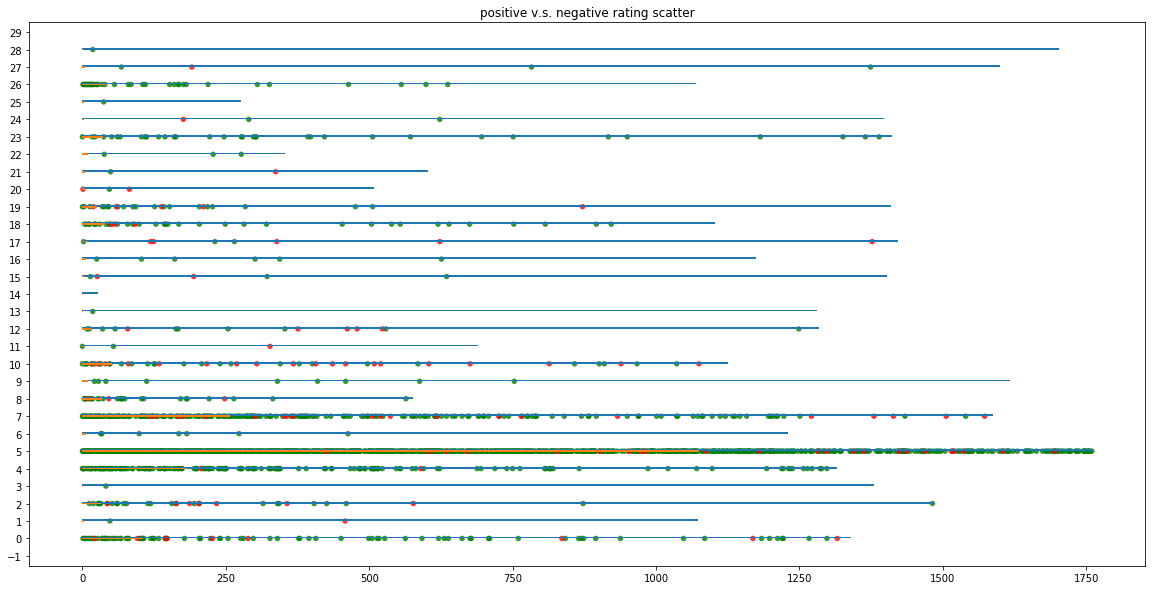

In [15]:
fig = plt.figure(figsize=(20,10))
plt.yticks(np.arange(-1, len(val_ids)+1, 1.0))

candidate_number = []
ground_truth_number = []

for idx, validate_id in enumerate(val_ids):
    similar_items = candidating.get_similar_items(metapath2vec_model, validate_id)
    ranked_users = candidating.get_ranked_candidates(user_item_tuple_train, similar_items)
    candidate_number.append(len(ranked_users))
    candidate_ids = [x[0] for x in ranked_users]
    positive = []
    y_p_axi = y_n_axi = [idx]
    for id in positive_ratings[positive_ratings['movieID']==validate_id]['userID'].values:
        if id in candidate_ids:
            positive.append(candidate_ids.index(id))
    plt.scatter(positive, y_p_axi*len(positive), alpha=0.8, c="green", edgecolors='none', s=30)
    
    negative = []
    for id in negative_ratings[negative_ratings['movieID']==validate_id]['userID'].values:
        if id in candidate_ids:
            negative.append(candidate_ids.index(id))
    
    implicit_count = len(positive_ratings[positive_ratings['movieID']==validate_id]) + len(negative_ratings[negative_ratings['movieID']==validate_id])
    ground_truth_number.append(implicit_count)
    plt.scatter(negative, y_n_axi*len(negative), alpha=0.8, c="red", edgecolors='none', s=30)

plt.barh(list(range(len(val_ids))),candidate_number, align="edge", height=0.1)
plt.barh(list(range(len(val_ids))),ground_truth_number, align="center", height=0.1)

plt.title('positive v.s. negative rating scatter')
plt.show()
    


In [38]:
g1

(array([1.06020867, 0.74419755, 0.65111685, 0.94994019, 1.03160651,
        0.8800527 , 1.01904582, 0.78108366, 0.61354079, 0.75509965,
        1.03826272, 1.04784399, 1.03466838, 0.60569562, 1.14945881,
        0.91792583, 0.89202872, 0.90038355, 0.77575252, 0.84013491,
        0.79475719, 0.95658606, 1.15656835, 0.6797386 , 0.87716046,
        0.66302956, 1.16040262, 0.91873978, 0.72127645, 0.70251743,
        0.92557852, 0.69539227, 0.95834819, 1.11447358, 0.88882126,
        0.84389877, 0.77295198, 0.70791013, 0.68577575, 0.9367159 ,
        0.642231  , 1.08909709, 0.62655369, 0.74162921, 1.06442677,
        0.7146213 , 0.73077809, 0.88530029, 0.84287596, 0.65339382,
        1.12795637, 0.82017752, 0.6020549 , 0.66437006, 0.86657861,
        0.78271588, 0.7129056 , 0.94982013, 0.95131244, 1.09949161]),
 array([0.56674558, 0.68599401, 0.71013415, 0.61404385, 0.51141526,
        0.66635842, 0.00109046, 0.11951555, 0.46781117, 0.83840103,
        0.31069871, 0.64249304, 0.83644416, 0.

In [ ]:
user_item_tuple_train[:5]

### Step 2: drift detection

#### create user-items and item-users mapping

In [ ]:
%%time
from collections import defaultdict

# user-items tuples based on candidate
candidate_items_tuple = user_item_tuple_train[user_item_tuple_train['userID'].isin([int(x) for x in candidate_ids])]

# user-items tuples based on all positive pairs
# candidate_items_tuple = user_item_tuple_train

user_items_dict = defaultdict(list)
candidate_items_subgraph = [user_items_dict[x['userID']].append(x['movieID']) for _, x in candidate_items_tuple.iterrows()]

item_users_dict = defaultdict(list)
item_candidates_subgraph = [item_users_dict[x['movieID']].append(x['userID']) for _, x in candidate_items_tuple.iterrows()]

def partition_vertices(user_id, partition_user_dict, partition_item_dict, partition_index):
    partition_user_dict[user_id] = partition_index
    grouped_candidate_list = []
    for item_id in user_items_dict[user_id]:
        if item_id not in partition_item_dict:
            partition_item_dict[item_id]=partition_index
            grouped_candidate_list += item_users_dict[item_id]
#     print(grouped_candidate_list)
    for related_user_id in set(grouped_candidate_list):
        if related_user_id not in partition_user_dict:
            partition_vertices(related_user_id, partition_user_dict, partition_item_dict, partition_index)

In [ ]:
print(len(user_items_dict))
print(len(item_users_dict))

#### create partition on user and item nodes

In [ ]:
import itertools
partition_user_dict={}
partition_item_dict={}
partition_count = 0

    
for user_id in candidate_ids:
    if user_id not in partition_user_dict:
        partition_vertices(user_id, partition_user_dict, partition_item_dict, partition_count)
        partition_count += 1

In [ ]:
partition_count